# Text classification with LSTM (RNN)

## Import Libraries

In [211]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
# import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
import matplotlib as mpl
from matplotlib import pyplot
import os
import jieba # 中文分词组件
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idgca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import data

In [57]:
def read_data(rootdir, target_name, target_index):
    
    for root, subdirs, files in os.walk(rootdir):
        for file in files:
            path = root+'/'+file
            with open(path, encoding="utf8") as f:
                input_file = f.read()
                data.append(input_file)
                target_names.append(target_name)
                target.append(target_index)

data = []
target_names = []
target = []
read_data("data/classification_data_v3/中性", "中性", 0)
read_data("data/classification_data_v3/买入", "买入", 1)
read_data("data/classification_data_v3/卖出", "卖出", 2)

In [58]:
# combine data to single dataframe
df = pd.DataFrame()
df['data'] = data
df['target_names'] = target_names
df['target'] = target


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23769 entries, 0 to 23768
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          23769 non-null  object
 1   target_names  23769 non-null  object
 2   target        23769 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 557.2+ KB


In [60]:
df.target_names.value_counts()
df.target.value_counts()

买入    17123
中性     6634
卖出       12
Name: target_names, dtype: int64

1    17123
0     6634
2       12
Name: target, dtype: int64

## Data exploration

In [62]:
df['target_names'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Documents', 
                                                                title='Number of Documents in each category')

In [63]:
# audit dataframe (check for nulls)
def table_info(data):
    tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'null values (%)'}))
    return tab_info

table_info(df)

,data,target_names,target
column type,object,object,int64
null values (nb),0,0,0
null values (%),0,0,0


## Data preprocessing

In [65]:
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(100)

 
 
 
公司报告 | 年报点评报告 
  
中科创达（300496） 证券研究报告  2020年 02月 27日 
投资评级 
5G应用核心标的，报表继续验证高景气度！ 行业 计算机/计算机应用 
6个月评级 增持（维持评级） 
  
事件 当前价格 68.15元 
目标价格  元 
公司发布年报，2019 年营收 18.27 亿元，同比增长 24.74%，归母净利润  
2.38亿元，同比增长 44.63%。 
 基本数据 
19年业绩整体符合预期，维持快速增长 A股总股本(百万股) 402.52 
流通 A股股本(百万股) 283.19  
公司实现归母净利润 2.38亿元，同比增长约 45%，位于此前业绩预告中值
A股总市值(百万元) 27,431.40 
47%附近，符合市场预期。扣非后净利润高增主要与收入端高增有关，公  
司实现收入 18.27亿元，同比增长 24.74%，整体符合预期。结构看，手机/ 流通 A股市值(百万元) 19,299.49  
汽车/物联网业务同比增长 14%/72%/13%。公司布局新一代网联汽车业务， 每股净资产(元) 4.76 
市场渗透率提升，收入持续高速增长。公司整体毛利率上升 0.92个百分点， 资产负债率(%) 30.41 
考虑商业模式逐步变化，我们看好新业务汽车软件毛利率持续改善，投入 一 年内最高/最低(元) 79.90/25.73 
产出比提升。  
20年 Q1扣非业绩增长 43%略超预期  作者 
沈海兵 分析师 
公司发布 20Q1 业绩预告，业绩增速预计中值约 30%符合预期，扣非业绩 SAC执业证书编号：S1110517030001 
有望达 6000万，同比增长 43%略超预期。收入保持高增长，预计超 30%， shenhaibing@tfzq.com 
我们判断主要与物联网业务出货加速和汽车业务保持高速增长有关，业务 缪欣君 分析师 
面向全球，19年海外收入占比 56%，公司通过远程协同办公等方式发力海 SAC执业证书编号：S1110517080003 
外业务，受疫情影响有限。 miaoxinjun@tfzq.com  
潘暕 分析师 
20年基本面有望逐季加速，高度看好 SAC执业证书编号：S1110517070005 
 panjian@tfzq.com 
5G 应用三大赛道景气度推

In [66]:
# df_backup = df

In [118]:
df = df_backup
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.。%-]')
# STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = text.replace('x', '')
    text = ''.join(re.findall(r'[\u4e00-\u9fa5]', text))
    wordlist = jieba.lcut(text) # partition
    text = ' '.join(word for word in wordlist) # combine
    return text

df['data'] = df['data'].apply(clean_text)
df['data'] = df['data'].str.replace('\d+', '') # remove all digits

In [119]:
# 文件内中文词汇，由空格分开
temp = df['data'][0]
temp

'公司 研究 类 模板 顺丰 控股 报告 日期 年月日 点评 报 市场份额 有望 持续 提升 告顺丰 控股 点评 报告 姜楠 执业 证书编号 评级 行 增持业 上次 评级 增持 公 当前 价格 司 投资 要点 研单 季度 业绩 元 股究 市场份额 有望 持续 提升 公司 业务量 市场份额 有望 持续 提升 年 自 特惠 专配 产品 推出 以物来 公司 单月 业务量 同比 增速 自月 起 持续 超越 行业 水平 全年 业务量 同流 比 增速 已 超过 行业 水平 年 月 月 全年 累计 公司 业务量 行市 占率 分别 为 在 疫情 的 影响 下 公司 相比 其他 主要 业 快递 企业 复工 率 更 高 配送 范围 更广 根据 交通运输 部 统计 截至 月 日 中国邮政 顺丰 和 京东 基本 全部 复工 其他 主要 快递 企业 整体 复工 率达 顺丰 控股 深证 成指 人工 和 运输成本 有望 节省 年 上半年 公司 的 人工 和 运输成本 有望 节省 受 疫情 防控 工作 下 出台 政策 的 影响 企业 的 人工成本 和 运输成本 有望 得到 节省 根据 交通运输 部 通知 月 日 零时 起 至 疫情 防控 工作 结束 全国 收费公路 免收 车辆通行 费 具体 截止 时间 另行通知 根据 国务院 常务会议 月 日 决定 阶段性 减免 企业 养老 失业 工伤保险 单位 缴费 以 减轻 疫情 对 企业 的 影响 结构 变化 是 价格 下滑 主因 产品 结构 变化 是 均价 同比 下降 的 主要 原因 年 月 公司 单票 收入 公司简介 元 同比 下降 主要 原因 是 均价 偏低 的 电商 件产品 占 比 提升 公司 是 国内 领先 的 快递 物流 综合 服务 年 月 供应链 业务收入 亿元 占 合计 收入 亿元 的 比例 商于 年 月 上市 截至 年 为 供应链 业务 的 发展 有助于 公司 拓展 新 客户 增加 现有 客户 粘性 底 公司 拥有 全 货机 架个 中转 以及 提高 资产 利用率 场干 支线 车辆 合计 万辆 各种 用工 模式 收 派员 约 万人 公司 的 物流 产 期待 高端 需求 爆发 和 机场 投产 后 成本 优化 品 主要 包含 时效 快递 经济 快递 同 预计 年 公司 归母 净利润 分别 为 亿元 亿元 城 配送 仓储 服务 国际 快递 等 亿元

## jieba library functions

In [85]:
wordlist = jieba.lcut(temp)
text = nltk.Text(wordlist)
print(text)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\idgca\AppData\Local\Temp\jieba.cache
Loading model cost 0.718 seconds.
Prefix dict has been built successfully.


<Text: 公司 报告 年报 点评 报告 中科 创达 证券...>


In [88]:
# 搜索上下文
text.concordance(word='报告',width=20,lines=10)

Displaying 10 of 33 matches:
公司 报告 年报 点评 报告
报告 年报 点评 报告 中科 创达 证券
创达 证券 研究 报告 年月日 投资 评
贝格 数据 相关 报告 中科 创达 季报
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 财务 预测 摘要
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 分析师 声明 本
分析师 声明 本 报告 署名 分析师 在
 胜任 能力 本 报告 所 表述 的 所


In [92]:
# 搜索共同上下文
text.common_contexts(['报告','公司'])
# 统计词频
text.count(word='报告')

No common contexts were found


33

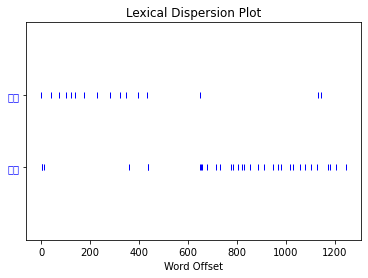

In [94]:
# 离散图
words=['公司','报告']
text.dispersion_plot(words)

In [97]:
# 计算相似度
text.similar(word='报告',num=10)

from nltk.text import ContextIndex
contentindex = ContextIndex(wordlist)
similarity_scores = contentindex.word_similarity_dict(word='报告')
for key,value in similarity_scores.items():
    if value>0.02:
        print(key,value)

发布
报告 1.0
发布 0.08333333333333333


## Tokenize documents

In [120]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 3000
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['data'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 301149 unique tokens.


## Save processed data to csv

In [134]:
df.to_csv(r'data/classification_data_v3/cleaned.csv',header=True,index=None)

In [132]:
def count_text(text):
    return len(text.split(' '))
    
df['word_count'] = df.data.apply(count_text)
df['word_count']

0        1844
1        3036
2        1238
3        1934
4        1551
         ... 
23764    1284
23765    2890
23766    1525
23767    1617
23768     371
Name: word_count, Length: 23769, dtype: int64

In [141]:
np.mean(df['word_count']) # each document has average 2500 words after processing 

2507.800244015314

## Get train test datasets

In [135]:
X = tokenizer.texts_to_sequences(df['data'].values)


In [150]:
MAX_SEQUENCE_LENGTH = 1000
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (23769, 1000)


In [216]:
Y = pd.get_dummies(df['target']).values
Y_single = df['target']
print('Shape of label tensor:', Y.shape)
print('Shape of label tensor:', Y_single.shape)

Shape of label tensor: (23769, 3)
Shape of label tensor: (23769,)



## Train test split

In [152]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19015, 1000) (19015, 3)
(4754, 1000) (4754, 3)


## LSTM

In [223]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 72

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 17113 samples, validate on 1902 samples
Epoch 1/3
17113/17113 [==============================] - 684s 40ms/step - loss: 0.5844 - accuracy: 0.7385 - val_loss: 0.5346 - val_accuracy: 0.7566
Epoch 2/3
17113/17113 [==============================] - 687s 40ms/step - loss: 0.5289 - accuracy: 0.7601 - val_loss: 0.5329 - val_accuracy: 0.7529
Epoch 3/3
17113/17113 [==============================] - 689s 40ms/step - loss: 0.5197 - accuracy: 0.7658 - val_loss: 0.5259 - val_accuracy: 0.7629


In [224]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4754/4754 [==============================] - 21s 4ms/step
Test set
  Loss: 0.520
  Accuracy: 0.759


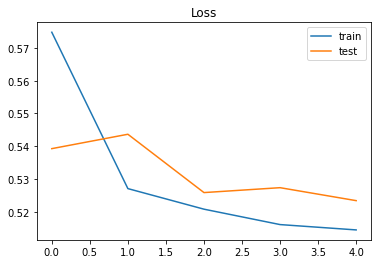

In [155]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

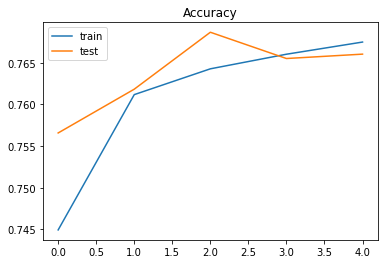

In [162]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [160]:
history.history


{'val_loss': [0.5392549102489379,
  0.5436472492889902,
  0.5258472341844336,
  0.527341907144721,
  0.5233879128841196],
 'val_accuracy': [0.7565720081329346,
  0.761829674243927,
  0.768664538860321,
  0.7655099630355835,
  0.7660357356071472],
 'loss': [0.5747780097204527,
  0.5270597410879122,
  0.5207833287097748,
  0.5160820137149704,
  0.5144538231555816],
 'accuracy': [0.74493074, 0.7611757, 0.76427275, 0.76602584, 0.7674867]}

In [210]:
pred = model.predict((X_test)) # [28:29,:]
pred

array([[2.7217430e-01, 7.2757405e-01, 2.5159252e-04],
       [2.7305761e-01, 7.2667521e-01, 2.6714511e-04],
       [1.8111259e-01, 8.1873506e-01, 1.5236292e-04],
       ...,
       [1.7219770e-01, 8.2754946e-01, 2.5281697e-04],
       [1.7943431e-01, 8.2046747e-01, 9.8176388e-05],
       [1.7481382e-01, 8.2509303e-01, 9.3145696e-05]], dtype=float32)

## Naive base

In [214]:
# pipeline
text_clf_nb = Pipeline([
#                         ('vect', CountVectorizer()), # attribute stop_words ("then, the, etc.")
#                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.01)), # FitPrior=False, a uniform prior will be used
                    ])

In [217]:
X_train, X_test, Y_single_train, Y_single_test = train_test_split(X,Y_single, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_single_train.shape)
print(X_test.shape,Y_single_test.shape)

(19015, 1000) (19015,)
(4754, 1000) (4754,)


In [219]:
text_clf_nb = text_clf_nb.fit(X_train, Y_single_train)

In [221]:
predicted = text_clf_nb.predict(X_test)
np.mean(predicted == Y_single_test)

0.652923853596971